<div class="head0">
    <div class="head0__name">
        TMP file
    </div>
</div>

In [2]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

import tt

sys.path.extend(['./../lib', './../helpers'])
from intertrain import Intertrain
from solver import Solver as Solver
from helpers import init_jupyter

init_jupyter()

Start |  4:55PM MSK on Sep 17, 2019 |
-------------------------------------


Let solve a matrix equation 
$$
    A W + W A^{\top} = Q,
$$
for the unknown matrix $W$.

In [7]:
from scipy.linalg import solve_lyapunov

A = np.array([
    [1., 3., 1.],
    [5., 1., 2.],
    [0., 9., 1.],
])
Q = np.array([
    [1., 0., 1.],
    [0., 1., 0.],
    [1., 1., 1.],
])

W = solve_lyapunov(A, Q)
e = np.linalg.norm(A @ W + W @ A.T - Q)
print('Error is : %-8.2e'%e)

Error is : 1.30e-14


Let check that
$$
    e^{A I_B + I_A B} = e^{A} \otimes e^{B}.
$$

In [9]:
Ia = np.eye(6)
Ib = np.eye(7)

A = np.random.randn(*Ia.shape)
B = np.random.randn(*Ib.shape)

E1 = expm(np.kron(A, Ib) + np.kron(Ia, B))
Ea = expm(A)
Eb = expm(B)
E2 = np.kron(Ea, Eb)
err = np.linalg.norm(E1 - E2) / np.linalg.norm(E1)

print('%-8.2e'%err)

1.19e-15


Let check that
$$
    e^{A I_B I_C + I_A B I_C + I_A I_B C} = e^{A} \otimes e^{B} \otimes e^{C}.
$$

See [forum](https://math.stackexchange.com/questions/709114/how-to-prove-ea-oplus-b-ea-otimes-eb-where-a-and-b-are-matrices)

In [10]:
Ia = np.eye(6)
Ib = np.eye(7)
Ic = np.eye(8)

A = np.random.randn(*Ia.shape)
B = np.random.randn(*Ib.shape)
C = np.random.randn(*Ic.shape)

E1 = expm(np.kron(np.kron(A, Ib), Ic) + np.kron(Ia, np.kron(B, Ic)) + np.kron(Ia, np.kron(Ib, C)))
Ea = expm(A)
Eb = expm(B)
Ec = expm(C)
E2 = np.kron(Ea, np.kron(Eb, Ec))
err = np.linalg.norm(E1 - E2) / np.linalg.norm(E1)

print('%-8.2e'%err)

8.63e-16


In [12]:
s_coef = 1.
D_coef = 0.5
t_min, t_max, t_poi = +0., +0.01, 100
x_min, x_max, x_poi = -3., +3., 11

d = 3
n = x_poi

IT = Intertrain(n=[x_poi, x_poi, x_poi], l=[[x_min, x_max], [x_min, x_max], [x_min, x_max]])

I0 = np.eye(n)
D0 = IT.dif2() * D_coef

D = np.zeros((n**d, n**d))
for i in range(d):
    M = [I0] * d; M[i] = D0
    Q = M[0].copy()
    for j in range(1, d):
        Q = np.kron(Q, M[j])
    D+= Q

Z = expm((t_max - t_min) * D)
E1 = Z

Z0 = expm((t_max - t_min) * D0)
Z = Z0.copy()
for _ in range(1, d): Z = np.kron(Z, Z0)
E2 = Z

err = np.linalg.norm(E1 - E2) / np.linalg.norm(E1)

print('%-8.2e'%err)

4.73e-16


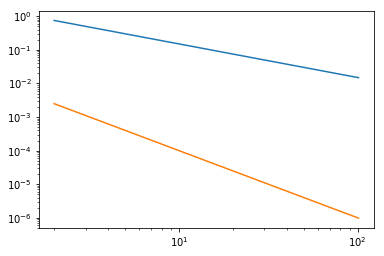

In [9]:
x = np.arange(100) + 2.
y = np.sin(x)

plt.plot(x, 1.5/x)
plt.plot(x, 0.01/x/x)
plt.semilogx()
plt.semilogy()
plt.show()

In [2]:
from config import config
import matplotlib.pyplot as plt

x = np.arange(100)
y = np.sin(x)

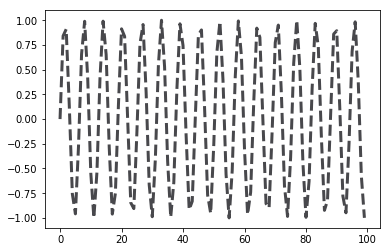

In [3]:
plt.plot(x, y, **config['opts']['plot']['line']['l1'])
plt.show()

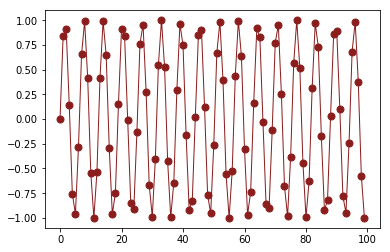

In [4]:
plt.plot(x, y, **config['opts']['plot']['line']['l2'])
plt.show()

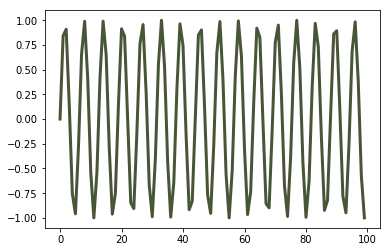

In [9]:
plt.plot(x, y, **config['opts']['plot']['line']['l3'])
plt.show()

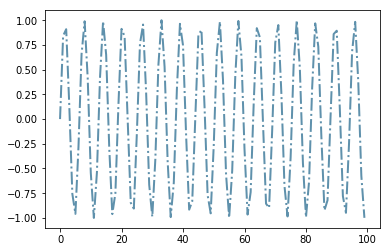

In [10]:
plt.plot(x, y, **config['opts']['plot']['line']['l4'])
plt.show()

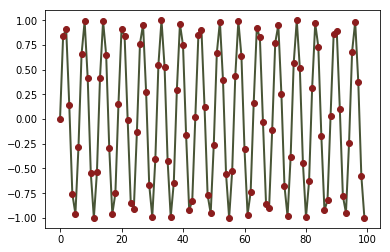

In [11]:
plt.plot(x, y, **config['opts']['plot']['line']['l5'])
plt.show()

<div class="head1">
    <div class="head1__name">
        Tests for solver in the TT-format
    </div>
</div>

In [3]:
s = 10.
Dc = 1.

def func_f0(x, t):
    return np.zeros(x.shape)

def func_f1(x, t):
    return np.zeros(x.shape)

def func_r0(x):
    r = np.exp(-1. * np.sum(x*x, axis=0) / (2. * s))
    r/= np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rt(x, t):
    r = np.exp(-1. * np.sum(x*x, axis=0) / (2. * s + 4. * Dc * t))
    r/= np.sqrt(2. * np.pi * s + 4. * np.pi * Dc * t)
    return r.reshape(-1)

def func_rs(x):
    return np.zeros(x.shape[1])

t_poi = 10
t_min = 0.
t_max = 10.

x_poi = 15
x_min = -5.
x_max = +5.

SL = Solver(d=3, with_tt=True)
SL.set_grid_t(t_poi, t_min, t_max, t_hst=10)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.set_coefs(Dc)

SL.prep()
SL.calc()


Solve:  22%|▏| 2/9 [00:07<00:26,  3.84s/step, | At T=2.22e+00 : n=5.52e-02 e=9.80e-01 es=9.80e-01]

ZeroDivisionError: float division by zero

<div class="head1">
    <div class="head1__name">
        Various
    </div>
</div>

In [7]:
n = [2, 3, 4]
N = np.prod(n)
A = np.arange(N*N).reshape(N, N)
i = np.array([
    [0, 1, 1, 0],
    [1, 2, 2, 0],
    [2, 3, 2, 1]
])
print(np.unravel_index(8, n, order='F'))

k = np.ravel_multi_index(i, n, order='F')
print(k)
A[np.ix_(k, k)]

(0, 1, 1)
[14 23 17  6]


array([[350, 359, 353, 342],
       [566, 575, 569, 558],
       [422, 431, 425, 414],
       [158, 167, 161, 150]])

In [12]:
t_poi = 10
t_hst = 4
t_hst = int(t_poi / t_hst) if t_hst else 0
for i in range(t_poi):
    if t_hst and (i % t_hst == 0 or i == t_poi - 1):
        print(i, t_hst)

0 2
2 2
4 2
6 2
8 2
9 2


<div class="head1">
    <div class="head1__name">
        Proof of analytic formula for solution of 1D PDF with linear drift
    </div>
</div>

Let calculate PDF $\rho(x, t)$ at time $t$ in some spatial point $x$ using transition PDF $\rho(x, t, x_0)$
$$
  \rho(x, t, x_0) =
      \frac{1}{\sqrt{2 \pi \Sigma(t)}}
      \exp{\left[
          -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}
      \right]},
$$
and fixed initial condition
$$
  \rho_0(x) =
      \frac{1}{\sqrt{2 \pi s}}
      \exp{\left[
          -\frac{x^2}{2 s}
      \right]},
$$
from equation
$$
  \rho(x, t) = \int_{-\infty}^{\infty}
      \rho(x, t, x_0) \rho_0(x_0) \, d x_0.
$$

We have
$$
  \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
      \exp{\left[
          -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}  -\frac{x_0^2}{2 s}
      \right]}
      \, d x_0,
$$

$$
  \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
      \exp{\left[
          -\frac{s (x - e^{-A t} x_0)^2 + \Sigma(t) x_0^2}{2 \Sigma(t) s}
      \right]}
      \, d x_0,
$$

$$
  \rho(x, t) =
      \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
      \exp{\left[
          -\frac{x^2}{2 \Sigma(t)}
      \right]}
      \int_{-\infty}^{\infty}
          \exp{\left[
              \frac{- s e^{-2 A t} x_0^2 + 2 s x e^{-A t} x_0 - \Sigma(t) x_0^2}{2 \Sigma(t) s}
          \right]}
          \, d x_0,
$$

$$
  \rho(x, t) =
      \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
      \exp{\left[
          -\frac{x^2}{2 \Sigma(t)}
      \right]}
      \int_{-\infty}^{\infty}
          \exp{\left[
              - \frac{s e^{-2 A t} + \Sigma(t)}{2 \Sigma(t) s} x_0^2
              + \frac{x e^{-A t}}{\Sigma(t)} x_0
          \right]}
          \, d x_0,
$$

Since
$$
  \int_{-\infty}^{\infty} e^{-a x^2 + b x} \, d x =
      \sqrt{\frac{\pi}{a}} e^{\frac{b^2}{4a}},
  \quad
  a > 0,
$$
we come to
$$
  \rho(x, t) =
      \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
      \exp{\left[
          -\frac{x^2}{2 \Sigma(t)}
      \right]}
      \sqrt{\frac{2 \pi \Sigma(t) s}{s e^{-2 A t} + \Sigma(t)}}
      \exp{\left[
          \frac{2 \Sigma(t) s x^2 e^{-2 A t}}{4 \Sigma^2(t) (s e^{-2 A t} + \Sigma(t))}
      \right]},
$$

$$
  \rho(x, t) =
      \sqrt{
          \frac
              {
                  1
              }
              {
                  2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
              }
      }
      \exp{\left[
          \frac
              {
                  s x^2 e^{-2 A t}
              }
              {
                  2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
              }
          -
          \frac
              {
                  x^2
              }
              {
                  2 \Sigma(t)
              }
      \right]},
$$

$$
  \rho(x, t) =
      \sqrt{
          \frac
              {
                  1
              }
              {
                  2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
              }
      }
      \exp{\left[
          \frac
              {
                  s e^{-2 A t} - s e^{-2 A t} - \Sigma(t)
              }
              {
                  2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
              }
          x^2
      \right]},
$$

$$
  \rho(x, t) =
      \frac
          {
              1
          }
          {
              \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
          }
      \exp{\left[
          - \frac
              {
                  x^2
              }
              {
                  2 \left( \Sigma(t) + s e^{-2 A t} \right)
              }
      \right]}.
$$

<div class="end"></div>